# Data Modelling for Arrivals

### Load Libraries
Load the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,recall_score,precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
metar_decoded_engineered = pd.read_csv('../data/metar_decoded_engineered.csv')
metar_decoded_engineered.head()

,Unnamed: 0,AIRPORT_IATA,Date,Hour,Wind_direction_imp,Wind_speed_imp,Temperature_imp,Dew_point_imp,Pressure_imp
0,0,LHR,2019-05-18,23,10.0,3.0,11.0,9.0,1009.0
1,1,LHR,2019-05-18,23,20.0,2.0,10.0,8.0,1009.0
2,2,LHR,2019-05-18,22,40.0,2.0,12.0,9.0,1009.0
3,3,LHR,2019-05-18,22,60.0,2.0,12.0,9.0,1008.0
4,4,LHR,2019-05-18,21,360.0,2.0,13.0,9.0,1008.0


In [4]:
metar_decoded_engineered = metar_decoded_engineered.drop('Unnamed: 0',axis=1)

In [5]:
len(metar_decoded_engineered)

13477

In [6]:
len(metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour']))

8211

In [7]:
weather_parameters_mean = pd.DataFrame({
    'Wind_direction' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Wind_direction_imp'].mean(),
    'Wind_speed' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Wind_speed_imp'].mean(),
    'Temperature' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Temperature_imp'].mean(),
    'Dew_point' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Dew_point_imp'].mean(),
    'Pressure' : metar_decoded_engineered.groupby(['AIRPORT_IATA','Date','Hour'])['Pressure_imp'].mean()}).reset_index()

In [8]:
arrivals_extended = pd.read_csv('../data/arrivals_extended_egineered.csv')

In [9]:
arrival_merge = pd.merge(arrivals_extended, weather_parameters_mean, how='inner', left_on=['flight_destination_code_iata','Date_arrivals','Hour_arrivals'], right_on=['AIRPORT_IATA','Date','Hour'])
arrival_merge.head()

,Unnamed: 0,index,mode,flight_number,airline_name,airline_iata,flight_origin_code_iata,flight_origin_name,flight_destination_code_iata,flight_destination_name,...,Hour_arrivals,Date_arrivals,AIRPORT_IATA,Date,Hour,Wind_direction,Wind_speed,Temperature,Dew_point,Pressure
0,0,0,arrivals,JL41,Japan Airlines,JL,HND,Tokyo Haneda International Airport,LHR,London Heathrow Airport,...,6,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0
1,1,1,arrivals,SA234,South African Airways,SA,JNB,Johannesburg OR Tambo International Airport,LHR,London Heathrow Airport,...,6,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0
2,2,2,arrivals,QF1,Qantas,QF,SIN,Singapore Changi Airport,LHR,London Heathrow Airport,...,6,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0
3,3,3,arrivals,BI3,Royal Brunei Airlines,BI,BWN,Brunei International Airport,LHR,London Heathrow Airport,...,6,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0
4,4,4,arrivals,VS4,Virgin Atlantic,VS,JFK,New York John F. Kennedy International Airport,LHR,London Heathrow Airport,...,6,2019-05-20,LHR,2019-05-20,6,335.0,4.5,13.0,11.0,1012.0


In [10]:
arrival_merge.isnull().sum()

Unnamed: 0                         0
index                              0
mode                               0
flight_number                      0
airline_name                       0
airline_iata                       0
flight_origin_code_iata            0
flight_origin_name                 0
flight_destination_code_iata       0
flight_destination_name            0
flight_departure_scheduled         0
flight_departure_real           6014
flight_arrival_scheduled           0
flight_arrival_real             8813
flight_duaration                9230
target                             0
Hour_departures                    0
Date_departures                    0
Hour_arrivals                      0
Date_arrivals                      0
AIRPORT_IATA                       0
Date                               0
Hour                               0
Wind_direction                     0
Wind_speed                         0
Temperature                        0
Dew_point                          0
P

In [11]:
arrival_merge.fillna(0, inplace=True)

In [12]:
arrival_merge = arrival_merge.drop(['Unnamed: 0','index', 'mode'],axis=1)
arrival_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127519 entries, 0 to 127518
Data columns (total 25 columns):
flight_number                   127519 non-null object
airline_name                    127519 non-null object
airline_iata                    127519 non-null object
flight_origin_code_iata         127519 non-null object
flight_origin_name              127519 non-null object
flight_destination_code_iata    127519 non-null object
flight_destination_name         127519 non-null object
flight_departure_scheduled      127519 non-null int64
flight_departure_real           127519 non-null float64
flight_arrival_scheduled        127519 non-null int64
flight_arrival_real             127519 non-null float64
flight_duaration                127519 non-null float64
target                          127519 non-null object
Hour_departures                 127519 non-null int64
Date_departures                 127519 non-null object
Hour_arrivals                   127519 non-null int64
Date_arriv

In [13]:
arrival_merge[['Wind_direction','Wind_speed','Temperature','Dew_point','Pressure','Hour','flight_duaration']].corr()

,Wind_direction,Wind_speed,Temperature,Dew_point,Pressure,Hour,flight_duaration
Wind_direction,1.000000,0.238764,-0.278542,-0.402548,0.141799,-0.014903,0.031974
Wind_speed,0.238764,1.000000,0.085183,-0.088216,-0.243991,0.037451,0.054882
Temperature,-0.278542,0.085183,1.000000,0.474694,-0.185170,0.126441,-0.087994
Dew_point,-0.402548,-0.088216,0.474694,1.000000,-0.260982,0.022480,-0.007420
Pressure,0.141799,-0.243991,-0.185170,-0.260982,1.000000,0.025847,-0.111119
Hour,-0.014903,0.037451,0.126441,0.022480,0.025847,1.000000,-0.057834
flight_duaration,0.031974,0.054882,-0.087994,-0.007420,-0.111119,-0.057834,1.000000


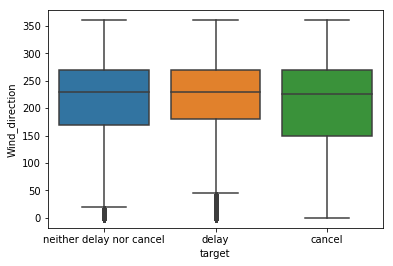

In [14]:
sns.boxplot(x="target",y="Wind_direction",data=arrival_merge)

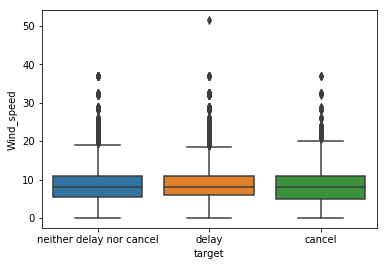

In [15]:
sns.boxplot(x="target",y="Wind_speed",data=arrival_merge)

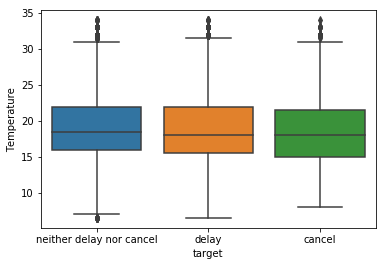

In [16]:
sns.boxplot(x="target",y="Temperature",data=arrival_merge)

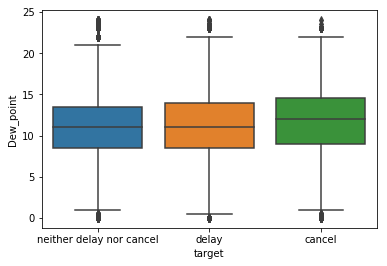

In [17]:
sns.boxplot(x="target",y="Dew_point",data=arrival_merge)

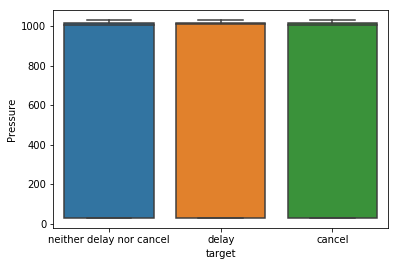

In [18]:
sns.boxplot(x="target",y="Pressure",data=arrival_merge)

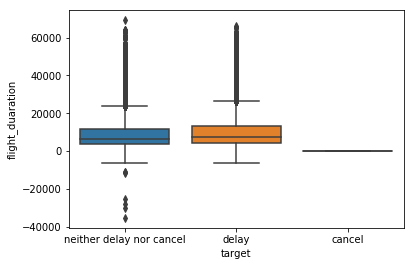

In [19]:
sns.boxplot(x="target",y="flight_duaration",data=arrival_merge)

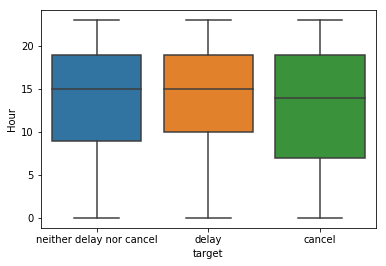

In [20]:
sns.boxplot(x="target",y="Hour",data=arrival_merge)

In [21]:
catg_encod = LabelEncoder()
arrival_merge["airline_name_catg"] = catg_encod.fit_transform(arrival_merge["airline_name"])
arrival_merge["flight_origin_name_catg"] = catg_encod.fit_transform(arrival_merge["flight_origin_name"])
arrival_merge["flight_destination_name_catg"] = catg_encod.fit_transform(arrival_merge["flight_destination_name"])

In [22]:
arrival_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127519 entries, 0 to 127518
Data columns (total 28 columns):
flight_number                   127519 non-null object
airline_name                    127519 non-null object
airline_iata                    127519 non-null object
flight_origin_code_iata         127519 non-null object
flight_origin_name              127519 non-null object
flight_destination_code_iata    127519 non-null object
flight_destination_name         127519 non-null object
flight_departure_scheduled      127519 non-null int64
flight_departure_real           127519 non-null float64
flight_arrival_scheduled        127519 non-null int64
flight_arrival_real             127519 non-null float64
flight_duaration                127519 non-null float64
target                          127519 non-null object
Hour_departures                 127519 non-null int64
Date_departures                 127519 non-null object
Hour_arrivals                   127519 non-null int64
Date_arriv

In [23]:
clf = RandomForestClassifier(n_estimators=150, max_depth=30,random_state=0)
model = clf.fit(arrival_merge[['airline_name_catg','flight_origin_name_catg','flight_destination_name_catg','Wind_direction', 'Wind_speed', 'Temperature',
                       'Dew_point', 'Pressure','flight_duaration', 'Hour']], arrival_merge['target'])

In [24]:
pred = clf.predict(arrival_merge[['airline_name_catg','flight_origin_name_catg','flight_destination_name_catg','Wind_direction', 'Wind_speed', 'Temperature',
                       'Dew_point', 'Pressure','flight_duaration', 'Hour']])

In [25]:
confusion_matrix(arrival_merge['target'],pred)

array([[ 5591,     0,     6],
       [    1, 39482,    61],
       [   10,    10, 82358]])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(arrival_merge[['airline_name_catg','flight_origin_name_catg','flight_destination_name_catg','Wind_direction', 'Wind_speed', 'Temperature',
                                                                   'Dew_point', 'Pressure','flight_duaration', 'Hour']], arrival_merge['target']
                                                    , test_size=0.30, random_state=35)

In [27]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Tuning Random Forest Classifier  

In [28]:
# Creating the parameters list 
param_dist = {"max_depth": [3, 5,10,15,20],
              "max_features": [2,4],
              "min_samples_split": [10, 100, 500],
              "bootstrap": [True, False],
              "n_estimators": [10, 20, 30, 50, 100, 200],
              "criterion": ["gini", "entropy"]}

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score,average='weighted')

# Perform random search on the classifier using the f1_scorer as the scoring method
random_obj = RandomizedSearchCV(clf, scoring=f1_scorer, param_distributions=param_dist, cv=5)

# Fit the random search object to the training data and find the optimal parameters
random_obj = random_obj.fit(X_train,y_train)

In [29]:
# Get the estimator
clf = random_obj.best_estimator_
print(random_obj.best_params_)

{'n_estimators': 100, 'min_samples_split': 10, 'max_features': 2, 'max_depth': 20, 'criterion': 'entropy', 'bootstrap': True}


In [30]:
# Prediction for testing set
y_pred = clf.predict(X_test)
    
# Print the results of prediction for testing set
print("F1 score for test set: {:.4f}".format((f1_score(y_test, y_pred, average='weighted'))))
print("Accuracy for test set: {:.4f}".format((np.mean(y_test == y_pred))))

F1 score for test set: 0.7040
Accuracy for test set: 0.7310


### Accuracy for individual classes

In [31]:
confusion_matrix(y_test, y_pred, labels=['neither delay nor cancel', 'delay', 'cancel'])

array([[22392,  1952,   457],
       [ 7689,  4034,    21],
       [  173,     0,  1538]])

In [32]:
test_label = pd.DataFrame(y_test)
test_label['target predicted'] = y_pred

In [33]:
test_label_cancel = test_label[test_label.target == 'cancel']
print("Accuracy for cancel: {:.4f}".format((np.mean(test_label_cancel.target == test_label_cancel['target predicted']))))

Accuracy for cancel: 0.8989


In [34]:
test_label_delay = test_label[test_label.target == 'delay']
print("Accuracy for delay: {:.4f}".format((np.mean(test_label_delay.target == test_label_delay['target predicted']))))

Accuracy for delay: 0.3435


In [35]:
test_label_neither = test_label[test_label.target == 'neither delay nor cancel']
print("Accuracy for neither delay nor cancel: {:.4f}".format((np.mean(test_label_neither.target == test_label_neither['target predicted']))))

Accuracy for neither delay nor cancel: 0.9029
